# Small demo of how to create a graph with G-PCGRL

* We load a pretrained model and control it to create a graph of 6 nodes using the set of constraints 1 from the paper.

In [1]:
%load_ext autoreload
%autoreload 2

import warnings

from stable_baselines3.ppo import PPO
from stable_baselines3.ppo.policies import MlpPolicy

from graph_helper import build_graph_map, init_graph_random
from gym_pcgrl.envs.probs.graph_prob import NodeType
from gym_pcgrl.wrappers_graph import GraphWrapper

warnings.filterwarnings('ignore')

In [2]:
# define rule set (this is Set 4, see paper for details)
rules = {
    NodeType.A: [NodeType.B],
    NodeType.B: [NodeType.A, NodeType.C, NodeType.B],
    NodeType.C: [NodeType.B]
}

In [3]:
# define configuration to control model
conf = {
    NodeType.A: 3,
    NodeType.B: 2,
    NodeType.C: 1
}

def init_graph(random, width, height, prob, *args, **kwargs):
    return build_graph_map(conf, random, width)

In [4]:
representation = "widegraph"
size = 6
max_changes = 12 # care: models are very sensitive to allowed number of maximum changes.

env_config = {
    "width": size,
    "height": size,
    "node_types": 6,
    "rules": rules,
    "init_random_map": init_graph, # to use random configs use the init_graph_random function 
    "render_mode": "rgb_array"
}

env_name = '{}-{}-v0'.format("graph", representation)

env = GraphWrapper(env_name, **env_config)
env.unwrapped.adjust_param(max_changes=max_changes)
obs, info = env.reset()

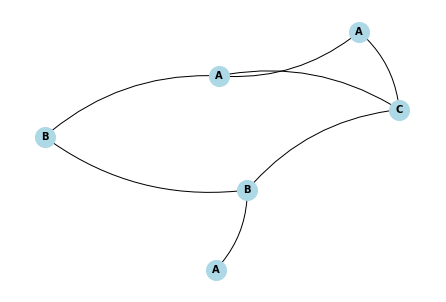

Is graph valid? False


In [5]:
# render current graph (random)
env.unwrapped.render(mode="graph")

print("Is graph valid?", info["valid"])

In [6]:
# load pretrained PPO model controllable up to 6 nodes with Set 1
model = PPO(MlpPolicy, env).load("models/widegraph-SET4-size6-rules5-types3-c12.zip", env)

In [7]:
def inference(env, model_):
    obs, _ = env.reset()
    done = False
    reward_total = 0
    for i in range(200):
        if not done:
            action, _ = model_.predict(obs)
            obs, reward, done, trunc, info = env.step(action)
            reward_total += reward
            if done:
                break
    return env, info, reward_total

In [8]:
env, info, reward = inference(env, model)
print("Is graph valid?", info["valid"], "Reward:", reward)

Is graph valid? True Reward: 30


In [9]:
info

{'valid': True,
 'valids': 0,
 'num_edges': 9,
 'map': array([[3, 0, 0, 0, 0, 0],
        [0, 3, 0, 0, 0, 0],
        [1, 1, 4, 0, 0, 0],
        [1, 1, 1, 4, 0, 0],
        [0, 0, 1, 1, 3, 0],
        [0, 0, 1, 1, 0, 5]]),
 'iterations': 10,
 'changes': 10,
 'max_iterations': 100,
 'max_changes': 12}

#### Render valid graph

The graph satisfies all constraints defined above: A must be connected to B, B may be connected to A,B, and C, and C must be connected to B.

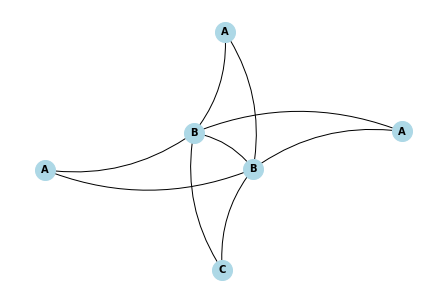

In [10]:
env.unwrapped.render(mode="graph")